## Simulacion

In [343]:
import numpy as np
import matplotlib.pyplot as plt 
import statistics as st
import pandas as pd
import scipy as sp
from scipy import interpolate
from ipywidgets import interact

In [233]:
#constantes útlies: 
hc = 1.98644586e-25 #[J.m]

In [234]:
elegans1 = pd.read_csv(r'/home/alejandro/Documents/Octavo/Intermedio/LabIntermedio/Proyecto/videos/Resultados7.csv')
elegans1.head()

,Slice,Mean
0,1,147.349
1,2,134.956
2,3,150.000
3,4,134.701
4,5,137.141


In [235]:
#Convertir el csv en una lista

Tiempo = 57
elegans1.head()
int1 = pd.DataFrame(elegans1,columns = ['Slice','Mean'])
int1.head()
type(int1.iloc[2,1])
señal1 = []
for i in range(len(int1)):
    señal1.append(int(int1.iloc[i,1]))

N = len(señal1)
dt = Tiempo/N
print(dt)

0.5480769230769231


In [236]:
## CARACTERÍSTICAS DE LA CÁMARA Y RUIDOS DE CAPTURACIÓN DE FOTONES Y DIGITALIZACIÓN DE LA SEÑAL


#ancho y alto de los pixeles
ancho = 6.5e-6 
alto = ancho

#cambiar intensidad en W/m^2 a número de fotones
#Tomado de "High-level numerical simulations of noise in CCD andCMOS photosensors: review and tutorial"
def Iph(Irad,ti,lam):
    global hc,ancho,alto
    Qp = hc/lam
    Pa = ancho*alto
    return np.round((Irad*Pa*ti)/Qp)

#Devolverme a intensidad en W/m^2
def InvIph(Iph,ti,lam):
    global hc,ancho,alto
    Qp = hc/lam
    Pa = ancho*alto
    return (Iph*Qp)/(Pa*ti)

#shot noise utilizando numpy.poisson
def ruidoPoiss(Iph): 
    #lam es la cantidad promedio de fotones que llega en un intervalo de tiempo definido
    yP = []
    for i in range(len(Iph)):
        yP.append(np.random.poisson(lam=abs(Iph[i])))
    return yP

#conversion a electrones
def QE(sig,value): #eficiencia cuántica
    sig = np.array(sig)
    return sig*value


#Ruido simplificado de lectura con numpy.normal
def ruidoLectura(sig,sigma):
    sigF = []
    for i in range(len(sig)):
        sigF.append(sig[i] + np.random.normal(0,sigma))
    return np.array(sigF)



#### Hasta ahora todo es enfocado en una neurona, después estas operaciones se tendrán que hacer sobre un conjunto de neuronas

In [237]:
def modulacion(t,w,I0,phi): #Esta es una intensidad modulada 
    #con la misma frecuencia que el Lock-in
    return I0*np.cos(w*t+phi)

def iluminacion(A): #iluminación uniforme. Si esta es más alta, 
    #el shot noise se vuelve menos importante
    return A
        
def DcOff(sig,Dc):
    new = []
    for i in range(len(sig)):
        new.append(sig[i]-Dc)
    return new

In [347]:
## iluminación y ruido en una sola función:

def deteccion(original, Amp, I0, frecuencia, dt, tf):
    
    #dt es el sampleo que se quiere (en caso de que toque interpolar)
    N = len(original)
    t = np.linspace(0,tf,N)
    if tf/N != dt:
        
        # interpolacion
        multi = (tf/N)/dt
       #cuantas veces queremos dividir el intervalo de tiempo original
        tnuevo = np.linspace(0,tf,round(multi*N)) 
        f = interpolate.interp1d(t,y, kind = 'cubic') #interpolación cúbica
        original = f(tnuevo)
        
    #Modulacion y ruido
    
    y_mod = original + I0*np.cos(tnuevo*frecuencia) + iluminacion(Amp) 
    #señal original iluminada con modulación
    y_no = original + iluminacion(Amp) 
    #señal original iluminada sin modulación
    
    #Conversión a fotones + shotNoise
    lam = 525e-9
    
    yP = ruidoPoiss(Iph(y_mod,dt,lam)) 
    yP2 = ruidoPoiss(Iph(y_no,dt,lam)) 

    # Añadir ruido de lectura de sigma = 2 electrones y eficiencia cuantica 
    yFinal = ruidoLectura(QE(yP,0.8),2)
    yFinal2 = ruidoLectura(QE(yP2,0.8),2)
    
    #fig, (ax1, ax2) = plt.subplots(2, 1,figsize = (10,10))
    
    #ax1.plot(tnuevo,y_mod,label='Iluminación')
    #ax1.plot(t,y, label = 'Original')

    #ax1.set(xlabel = 'Tiempo[s]', ylabel = r'Intensidad $[W/\mu m^2]$')
    #ax1.grid()
    #ax1.set_title('Original e iluminación')
    #ax1.legend()
    
    
    #ax2.plot(tnuevo,yFinal,label = 'Iluminación+Ruido')
    #ax2.set(xlabel = 'Tiempo[s]', ylabel = 'Intensidad [Número de electrones]')
    #ax2.set_title('Señal ruidosa digitalizada')
    #ax2.grid()
    #ax2.legend()
    
    #plt.show()
    
    return yFinal,yFinal2,tnuevo
    


    
    

In [348]:
Amp = 0.01e-3 #iluminacion uniforme
I0 = Amp/2 #iluminacion modulada
frecuencia = 100 #frecuencia lock in y modulacion
y = np.array(señal1)*4e4*1e-12
tf = 57
deteccion(y,Amp,I0,frecuencia,1/20,tf)

(array([104.98930858,  89.49709906,  62.81737827, ...,  34.25981516,
         47.40797039,  60.11700862]),
 array([62.34358491, 64.40098971, 71.52522921, ..., 50.64852903,
        43.94937756, 52.10352887]),
 array([0.00000000e+00, 5.00438982e-02, 1.00087796e-01, ...,
        5.68999122e+01, 5.69499561e+01, 5.70000000e+01]))

In [295]:
#definicion de Delta F/F0

def porcentaje(señal):
    #F0 es la intensidad basal del GCaMP
    prom = np.mean(señal)
    num = abs(señal-prom)
    return num/prom

## Lock In

In [296]:
from scipy import signal

0.3398076923076923


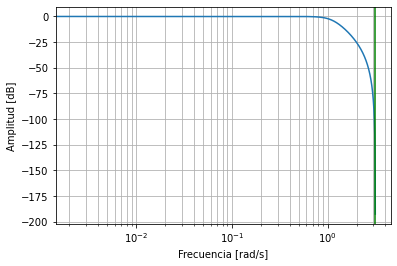

In [297]:
## Filtro Pasabajas
fs = multi/dt #frecuencia de sampleo
nyq = 0.5*fs
fc = 0.031*frecuencia #frecuencia de corte
nor= fc/nyq #frecuencia de corte normalizada
print(nor)

orden = 3

sos = signal.butter(orden,nor,'low',analog = False,output = 'sos') #Escogemos el orden y frecuencia del filtro) 
w, h = signal.sosfreqz(sos,1500)
db = 20*np.log10(np.abs(h))
plt.semilogx(w, db)
plt.grid(True, which = 'both')
plt.ylabel('Amplitud [dB]')
plt.xlabel('Frecuencia [rad/s]')
plt.axvline(fc, color='green') # cutoff frequency

In [365]:
## Lock in:

# señales de referencia
def referencia(w,t):
    t = np.array(t)
    y1 = np.cos(w*t)
    y2 = np.sin(w*t)
    return [y1,y2]


#Multiplicaciones 
def multiplicacion(signal,referencia):
    ref1 = referencia[0]
    ref2 = referencia[1]
    signal = np.array(signal)
    uno = np.multiply(ref1,signal) #multiplicacion coseno
    dos = np.multiply(ref2,signal) #multiplicacion seno
    return [uno,dos]


#Filtro
def Filtro(corte,orden,dt,frecuencia):#frecuecia es la frecuencia del LockIn
    fs = 1/dt #frecuencia de sampleo- Revisa bien que el dt está bien definido
    nyq = 0.5*fs #frecuencia de Nyquist
    fc = corte*frecuencia #frecuencia de corte #corte es un multiplo de la f del lockIn
    nor= fc/nyq #frecuencia de corte normalizada
    if nor > 1:
        print(nor, "esto debe estar entre 0 y 1")
        print('La frecuencia de sampleo es', fs)
        print('La frecuencia de corte es', fc)
    else:
        sos = signal.butter(orden,nor,'low',analog = False,output = 'sos') 
        return sos
    #Escogemos el orden y frecuencia del filtro) 

def LockIn(sig,corte,orden,dt,frecuencia,original,Amp): 
    
    
    t = sig[2] #array con dt correcto
    lam = 525e-9
    
    #creamos referencia y multiplicamos
    ref = referencia(frecuencia,t)
    m1 = multiplicacion(sig[0],ref)[0]
    m2 = multiplicacion(sig[0],ref)[1]
    
    #creamos filtros
    sos = Filtro(corte,orden,dt,frecuencia)
    
    #filtramos
    X = sp.signal.sosfilt(sos, m1)
    Y = sp.signal.sosfilt(sos, m2)
    filtro = sp.signal.sosfilt(sos, sig[1])
    
    #Cuadraturas
    X = np.array(X)
    Y = np.array(Y)

    #Amplitud 
    A = 2*np.sqrt(np.square(X)+np.square(Y))
    
    #fig, (ax1, ax2) = plt.subplots(2, 1,figsize = (10,10))
    
    #ax1.plot(t,sig[0],label = 'Original ruidosa')
    #ax1.plot(t,A,label='con Lock')
    #ax1.plot(t,filtro, label = 'Sin Lock')
    
    #ax1.set_title('Señales filtradas con o sin Lock-In')
    #ax1.grid()
    #ax1.legend()
    
    
    #N = len(original)
    #t_viejo = np.linspace(0,tf,N)
    #ax2.plot(t_viejo,original+iluminacion(Amp),label = 'original')
    #ax2.plot(t,InvIph(A,dt,lam),label='con Lock')
    #ax2.plot(t,InvIph(filtro,dt,lam),label='sin Lock')
    #ax2.grid()
    #ax2.legend()
    #ax2.set_title('Comparativa con la original')
    
    return A,filtro
    
    
    

In [378]:
Amp = 0.01e-3 #iluminacion uniforme
I0 = Amp/2 #iluminacion modulada
original = np.array(señal1)*4e4*1e-12
tf = 57
orden = 3
dt = 1/20
corte=0.08


@interact
def main(frecuencia = 100):
    global original
    global Amp
    global I0
    global dt
    global tf
    global orden
    global corte
    
    
    det = deteccion(original,Amp,I0,frecuencia,dt,tf)
    lok = LockIn(det,corte,orden,dt,frecuencia,original,Amp)
    N = len(original)
    t_viejo = np.linspace(0,tf,N)
    t_nuevo = det[2]
    
    plt.plot(t_nuevo,det[0],label = 'original')
    plt.plot(t_nuevo,lok[0], label = 'Con lock')
    plt.plot(t_nuevo,lok[1], label = 'Sin lock')
    plt.grid()
    plt.legend()
    
    return plt.figure()

interactive(children=(IntSlider(value=100, description='frecuencia', max=300, min=-100), Output()), _dom_class…

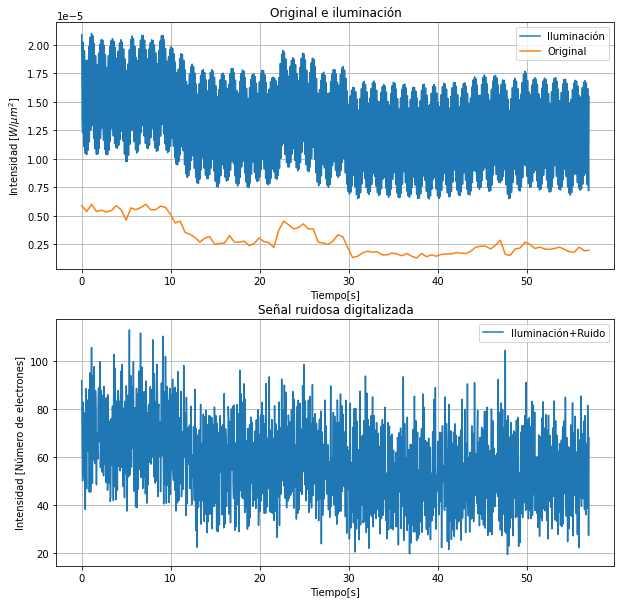

[array([ 1.        ,  0.28786894, -0.83426295, ..., -0.84355651,
       -0.75714112,  0.40764169]), array([ 0.        , -0.95766981, -0.55136679, ..., -0.53704042,
        0.65325135,  0.91314197])]


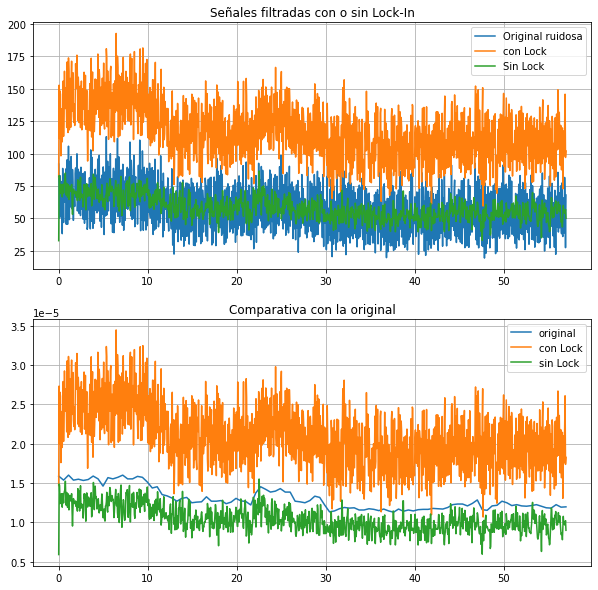

In [334]:
Amp = 0.01e-3 #iluminacion uniforme
I0 = Amp/2 #iluminacion modulada
frecuencia = 40 #frecuencia lock in y modulacion
y = np.array(señal1)*4e4*1e-12
tf = 57